In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'utkface-new:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F44109%2F78156%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240407%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240407T185656Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D699b8a937fc4ce421a75d39d5d9b9b226cc409aa93de3394fcdd0c9d7d8235c9aeab9497769363c55ae6a95d94c5d03eaff6ff0ee9df4204bcc3dcf625b42f1f293c1fe45d60f7cc6bc0ec2a4f17539411c1e72b8d39413a9a7f49d38d86395c2c7d69eb7d14d461d785aaeb56b079e9c0be257f3dc6cc4a5ae91a963b81d4faefaaab6c0428b99defe6381dad4e825bfcf1fe168df7626cd538de006d9859e5bb77e2c7f675938523d538dd50dbee87565879f593bcd804016b8bbf8f087304f3e3f6ef765717a9ea849cd29d8992a95350c7c3952166d88fd68cc3300b73e6257a64f11d8d82d153d5dec3df6d3ae1c2873eb950e78a29fe6d7bfcac2fcf69'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 347342542 bytes downloaded
Downloaded and uncompressed: utkface-new
Data source import complete.


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model, to_categorical, load_img
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Cropping2D, Resizing, concatenate

In [ ]:
BASE_DIR = '../input/utkface-new/UTKFace/'

In [ ]:
# labels - age, gender
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,../input/utkface-new/UTKFace/29_0_3_2017011917...,29,0
1,../input/utkface-new/UTKFace/21_1_2_2017010318...,21,1
2,../input/utkface-new/UTKFace/35_1_0_2017011709...,35,1
3,../input/utkface-new/UTKFace/35_0_0_2017010420...,35,0
4,../input/utkface-new/UTKFace/1_0_3_20161219225...,1,0


In [ ]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

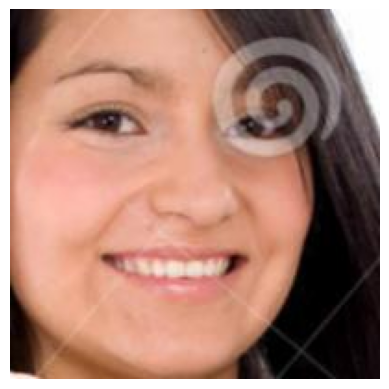

In [ ]:
from PIL import Image
img = Image.open(df['image'][100])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

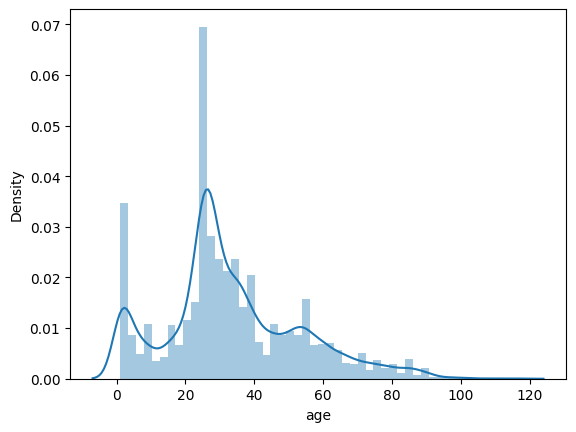

In [ ]:
sns.distplot(df['age'])

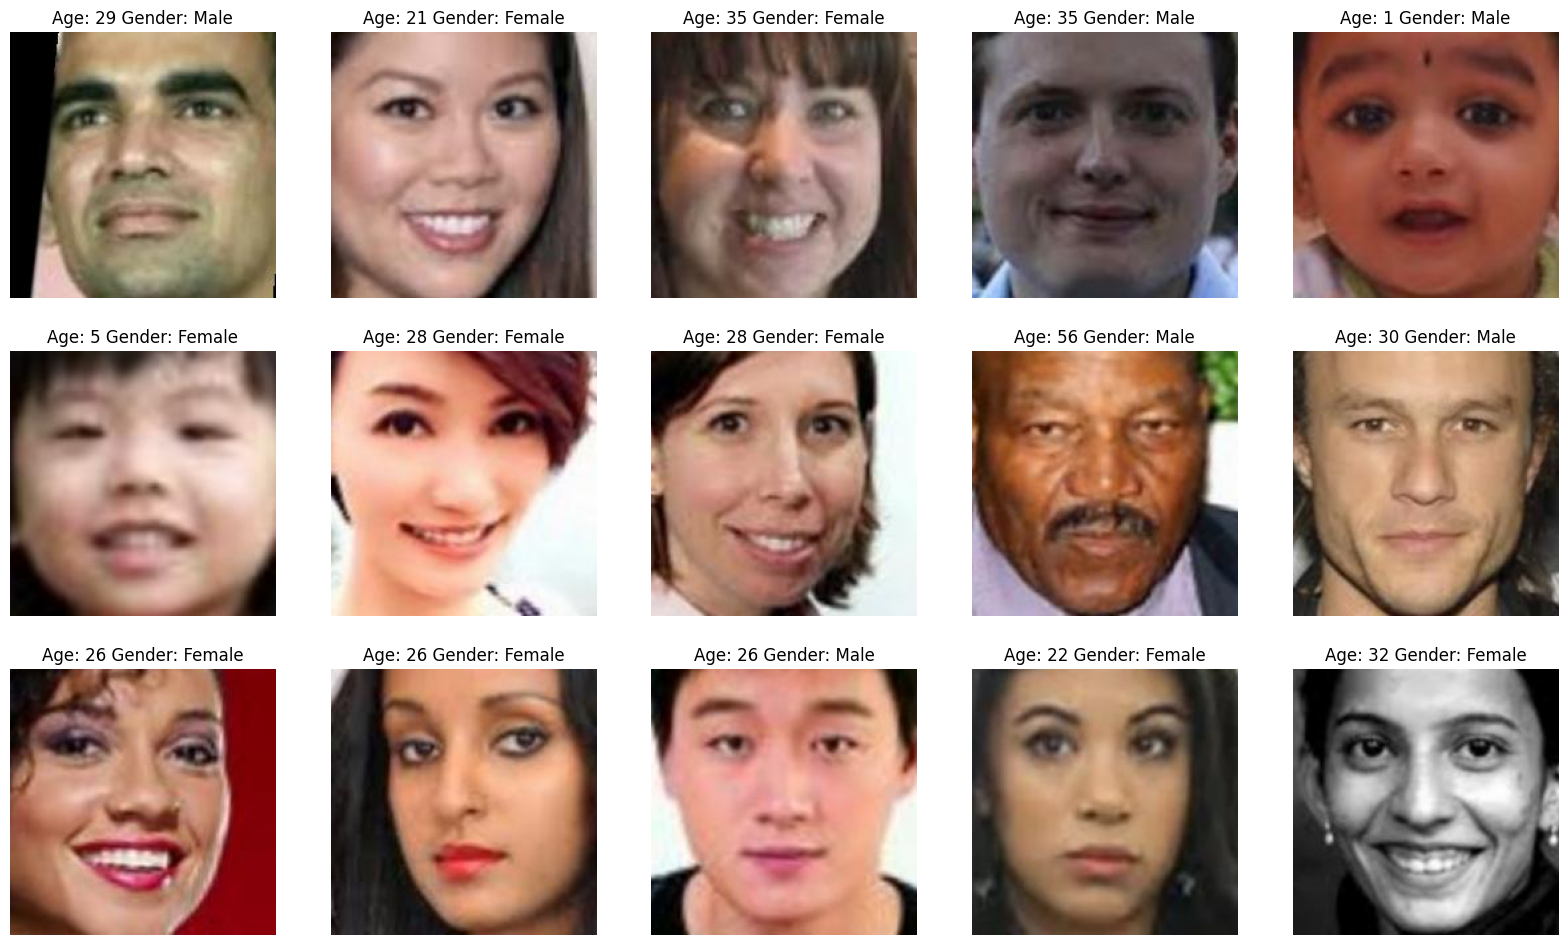

In [ ]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:15]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [ ]:
IMG_SIZE, CHANNEL = 128, 1
VAL_SPLIT = 0.2
LR_RATE = 2e-4
INITIAL_LEARN_RATE = 0.1
DECAY_STEP, DECAY_RATE = 1e5, 0.96
OPTIM = 0.0001
BATCH_SIZE, EPOCH = 16, 20


In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), IMG_SIZE, IMG_SIZE, CHANNEL)
    return features
X = extract_features(df['image'])
X.shape

  0%|          | 0/23708 [00:00<?, ?it/s]

(23708, 128, 128, 1)

In [ ]:
# normalize the images
X = X/255.0
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
input_shape = (IMG_SIZE, IMG_SIZE, CHANNEL)
inputs = Input((input_shape))

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate
from keras.models import Model
from keras.applications import DenseNet121

# Input layer for single-channel images
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

# Convert single-channel images to three channels (for compatibility with DenseNet)
rgb_inputs = concatenate([inputs, inputs, inputs])

# Create DenseNet backbone
densenet_backbone = DenseNet121(weights='imagenet', include_top=False, input_tensor=rgb_inputs)

# Freeze the backbone layers
for layer in densenet_backbone.layers:
    layer.trainable = False

# Flatten the output of DenseNet
densenet_output = Flatten()(densenet_backbone.output)

# Additional layers for joint processing
x = Dense(512, activation='relu')(densenet_output)
x = Dense(256, activation='relu')(x)

# Output layers
output_1 = Dense(1, activation='sigmoid', name='gender_out')(x)
output_2 = Dense(1, activation='relu', name='age_out')(x)

# Create model
model = Model(inputs=inputs, outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])


29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=VAL_SPLIT)


Epoch 1/20
1186/1186 [==============================] - 51s 32ms/step - loss: 9.7045 - gender_out_loss: 0.4925 - age_out_loss: 9.2120 - gender_out_accuracy: 0.8075 - age_out_accuracy: 0.0087 - val_loss: 8.8226 - val_gender_out_loss: 0.3740 - val_age_out_loss: 8.4486 - val_gender_out_accuracy: 0.8338 - val_age_out_accuracy: 0.0065
Epoch 2/20
1186/1186 [==============================] - 34s 29ms/step - loss: 8.1184 - gender_out_loss: 0.3612 - age_out_loss: 7.7572 - gender_out_accuracy: 0.8413 - age_out_accuracy: 0.0063 - val_loss: 7.8321 - val_gender_out_loss: 0.3527 - val_age_out_loss: 7.4793 - val_gender_out_accuracy: 0.8442 - val_age_out_accuracy: 0.0034
Epoch 3/20
1186/1186 [==============================] - 39s 33ms/step - loss: 7.5652 - gender_out_loss: 0.3308 - age_out_loss: 7.2344 - gender_out_accuracy: 0.8587 - age_out_accuracy: 0.0064 - val_loss: 7.9973 - val_gender_out_loss: 0.3550 - val_age_out_loss: 7.6422 - val_gender_out_accuracy: 0.8357 - val_age_out_accuracy: 0.0036
Epoc

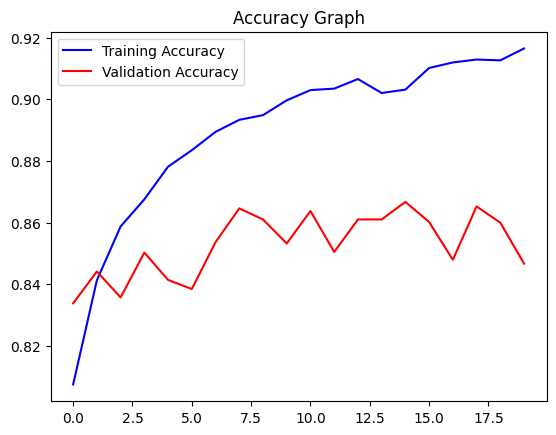

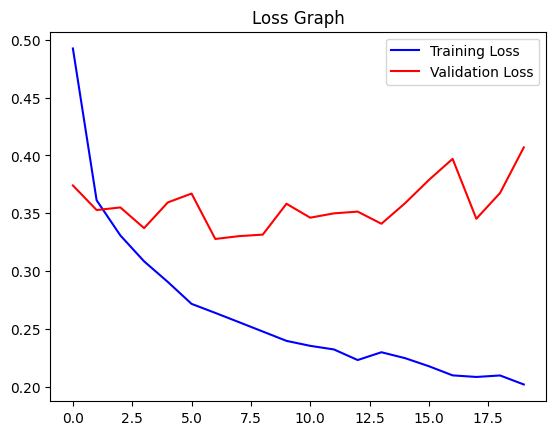

In [ ]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

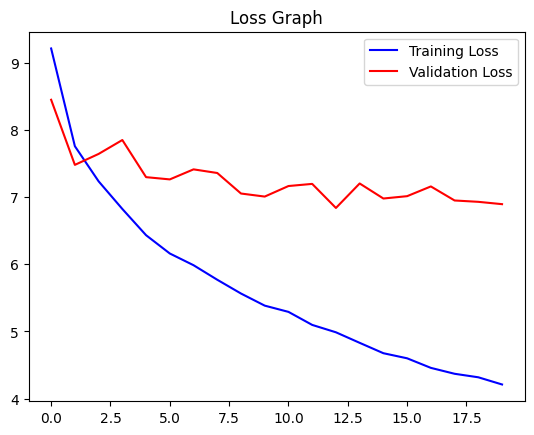

In [ ]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Male | Original Age: 39
1/1 [==============================] - 4s 4s/step
Predicted Gender: Male | Predicted Age: 38


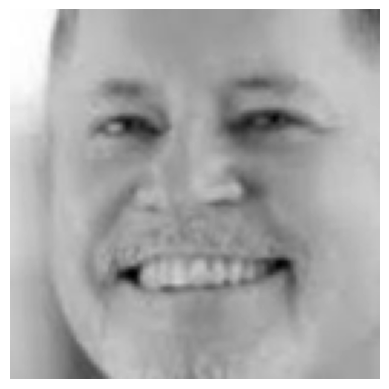

In [ ]:
image_index = 900
print("Original Gender:", gender_dict[y_gender[image_index]], "| Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, IMG_SIZE, IMG_SIZE, CHANNEL))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "| Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(IMG_SIZE, IMG_SIZE), cmap='gray');

Original Gender: Female | Original Age: 26
1/1 [==============================] - 0s 29ms/step
Predicted Gender: Female | Predicted Age: 26


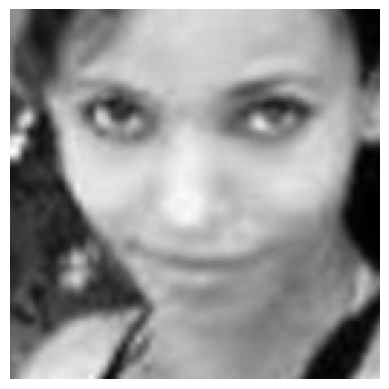

In [ ]:
image_index = 800
print("Original Gender:", gender_dict[y_gender[image_index]], "| Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, IMG_SIZE, IMG_SIZE, CHANNEL))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "| Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(IMG_SIZE, IMG_SIZE), cmap='gray');

Original Gender: Male | Original Age: 26
1/1 [==============================] - 0s 27ms/step
Predicted Gender: Male | Predicted Age: 28


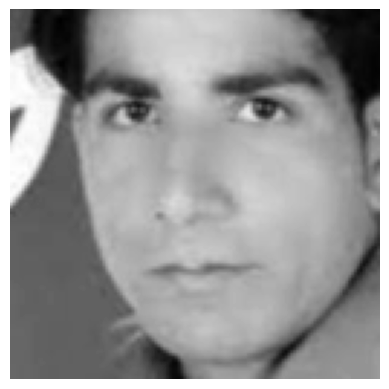

In [ ]:
image_index = 345
print("Original Gender:", gender_dict[y_gender[image_index]], "| Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, IMG_SIZE, IMG_SIZE, CHANNEL))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "| Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(IMG_SIZE, IMG_SIZE), cmap='gray');